In [ ]:
import zipfile
import os

zip_file_path = '/content/test_set.zip'
destination_folder = '/content/data'

os.makedirs(destination_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Unzipped files to: {destination_folder}")

Unzipped files to: /content/data


In [ ]:

!pip install -q torch torchvision pandas tqdm

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
from PIL import Image


torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BASE_PATH = '/content/Dataset'   

train_csv = os.path.join(BASE_PATH, 'train_labels.csv')
val_csv   = os.path.join(BASE_PATH, 'val_labels.csv')
train_dir = os.path.join(BASE_PATH, 'train')
val_dir   = os.path.join(BASE_PATH, 'val')

class CSVDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        assert 'file_name' in self.df.columns and 'label' in self.df.columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file_name'])
        image = Image.open(img_path).convert('RGB')
        label = int(row['label'])
        if self.transform:
            image = self.transform(image)
        return image, label


img_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])


train_set = CSVDataset(train_csv, train_dir, transform=train_transform)
val_set   = CSVDataset(val_csv,   val_dir,   transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)


teacher = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
teacher.fc = nn.Linear(teacher.fc.in_features, 2)
teacher = teacher.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


num_epochs = 50
best_acc = 0.0
save_path = os.path.join(BASE_PATH, 'finetuned_resnet50_2class.pth')

for epoch in range(num_epochs):
    teacher.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [train]'):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_set)

    teacher.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [val]'):
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = teacher(inputs)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    acc = correct / total

    print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f}')

    
    if acc > best_acc:
        best_acc = acc
        torch.save(teacher.state_dict(), save_path)
        print(f'  ---> BEST model saved (acc={best_acc:.4f})')

    scheduler.step()

print('=== RESNET-50 FINETUNING DONE ===')
print(f'Best val acc: {best_acc:.4f}')
print(f'Model saved to: {save_path}')

Epoch 1/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]


Epoch 1 | Loss: 0.2212 | Val Acc: 0.9649
  ---> BEST model saved (acc=0.9649)


Epoch 2/50 [val]: 100%|██████████| 13/13 [00:03<00:00,  4.06it/s]


Epoch 2 | Loss: 0.1080 | Val Acc: 0.9424


Epoch 3/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


Epoch 3 | Loss: 0.0954 | Val Acc: 0.9724
  ---> BEST model saved (acc=0.9724)


Epoch 4/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


Epoch 4 | Loss: 0.0676 | Val Acc: 0.9825
  ---> BEST model saved (acc=0.9825)


Epoch 5/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]


Epoch 5 | Loss: 0.0540 | Val Acc: 0.9649


Epoch 6/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Epoch 6 | Loss: 0.0922 | Val Acc: 0.9524


Epoch 7/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]


Epoch 7 | Loss: 0.0475 | Val Acc: 0.9799


Epoch 8/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


Epoch 8 | Loss: 0.0453 | Val Acc: 0.9799


Epoch 9/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]


Epoch 9 | Loss: 0.0606 | Val Acc: 0.9774


Epoch 10/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


Epoch 10 | Loss: 0.0357 | Val Acc: 0.9825


Epoch 11/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]


Epoch 11 | Loss: 0.0534 | Val Acc: 0.9574


Epoch 12/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]


Epoch 12 | Loss: 0.0550 | Val Acc: 0.9799


Epoch 13/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch 13 | Loss: 0.0382 | Val Acc: 0.9749


Epoch 14/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


Epoch 14 | Loss: 0.0378 | Val Acc: 0.9825


Epoch 15/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


Epoch 15 | Loss: 0.0427 | Val Acc: 0.9774


Epoch 16/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s]


Epoch 16 | Loss: 0.0251 | Val Acc: 0.9724


Epoch 17/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


Epoch 17 | Loss: 0.0245 | Val Acc: 0.9875
  ---> BEST model saved (acc=0.9875)


Epoch 18/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s]


Epoch 18 | Loss: 0.0230 | Val Acc: 0.9749


Epoch 19/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


Epoch 19 | Loss: 0.0321 | Val Acc: 0.9774


Epoch 20/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


Epoch 20 | Loss: 0.0368 | Val Acc: 0.9774


Epoch 21/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]


Epoch 21 | Loss: 0.0228 | Val Acc: 0.9850


Epoch 22/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


Epoch 22 | Loss: 0.0192 | Val Acc: 0.9799


Epoch 23/50 [val]: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Epoch 23 | Loss: 0.0167 | Val Acc: 0.9774


Epoch 24/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.32it/s]


Epoch 24 | Loss: 0.0146 | Val Acc: 0.9799


Epoch 25/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


Epoch 25 | Loss: 0.0158 | Val Acc: 0.9749


Epoch 26/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


Epoch 26 | Loss: 0.0111 | Val Acc: 0.9774


Epoch 27/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]


Epoch 27 | Loss: 0.0209 | Val Acc: 0.9774


Epoch 28/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.17it/s]


Epoch 28 | Loss: 0.0116 | Val Acc: 0.9774


Epoch 29/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


Epoch 29 | Loss: 0.0109 | Val Acc: 0.9799


Epoch 30/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]


Epoch 30 | Loss: 0.0099 | Val Acc: 0.9774


Epoch 31/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]


Epoch 31 | Loss: 0.0112 | Val Acc: 0.9799


Epoch 32/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.58it/s]


Epoch 32 | Loss: 0.0105 | Val Acc: 0.9799


Epoch 33/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


Epoch 33 | Loss: 0.0173 | Val Acc: 0.9749


Epoch 34/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]


Epoch 34 | Loss: 0.0127 | Val Acc: 0.9825


Epoch 35/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


Epoch 35 | Loss: 0.0128 | Val Acc: 0.9799


Epoch 36/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]


Epoch 36 | Loss: 0.0092 | Val Acc: 0.9774


Epoch 37/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


Epoch 37 | Loss: 0.0116 | Val Acc: 0.9825


Epoch 38/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]


Epoch 38 | Loss: 0.0050 | Val Acc: 0.9774


Epoch 39/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  4.39it/s]


Epoch 39 | Loss: 0.0120 | Val Acc: 0.9774


Epoch 40/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


Epoch 40 | Loss: 0.0117 | Val Acc: 0.9799


Epoch 41/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]


Epoch 41 | Loss: 0.0167 | Val Acc: 0.9825


Epoch 42/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


Epoch 42 | Loss: 0.0111 | Val Acc: 0.9799


Epoch 43/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.17it/s]


Epoch 43 | Loss: 0.0112 | Val Acc: 0.9799


Epoch 44/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s]


Epoch 44 | Loss: 0.0085 | Val Acc: 0.9749


Epoch 45/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.17it/s]


Epoch 45 | Loss: 0.0063 | Val Acc: 0.9799


Epoch 46/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s]


Epoch 46 | Loss: 0.0089 | Val Acc: 0.9774


Epoch 47/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


Epoch 47 | Loss: 0.0082 | Val Acc: 0.9774


Epoch 48/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


Epoch 48 | Loss: 0.0071 | Val Acc: 0.9774


Epoch 49/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


Epoch 49 | Loss: 0.0076 | Val Acc: 0.9774


Epoch 50/50 [val]: 100%|██████████| 13/13 [00:02<00:00,  5.99it/s]

Epoch 50 | Loss: 0.0067 | Val Acc: 0.9799
=== RESNET-50 FINETUNING DONE ===
Best val acc: 0.9875
Model saved to: /content/Dataset/finetuned_resnet50_2class.pth


In [ ]:
!pip install -q timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.vision_transformer import VisionTransformer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

class DeiTDistillSmall(VisionTransformer):
    def __init__(self, img_size=224, num_classes=2, distill=True):
        super().__init__(
            img_size=img_size,
            patch_size=16,
            embed_dim=384,
            depth=12,
            num_heads=6,
            mlp_ratio=4,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
            num_classes=num_classes
        )
        self.distill = distill
        if distill:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
            self.head_dist = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distill:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        if self.distill:
            cls_out = self.head(x[:, 0])
            dist_out = self.head_dist(x[:, 1])
            return cls_out, dist_out
        else:
            return self.head(x[:, 0])

student = DeiTDistillSmall(num_classes=2).cuda()

In [ ]:
import torch
import torchvision.models as models
from torchvision.models import ResNet50_Weights

teacher = models.resnet50(weights=None)  
teacher.fc = nn.Linear(teacher.fc.in_features, 2)
teacher = teacher.cuda()

teacher.load_state_dict(torch.load('/content/finetuned_resnet50_2class.pth'))

for param in teacher.parameters():
    param.requires_grad = False
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

temperature = 3.0   
alpha = 0.5          
beta = 0.5             

ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction='batchmean')

def distillation_loss(student_logits, teacher_logits, labels, T=temperature):
    """
    student_logits: [B, 2] from dist head
    teacher_logits: [B, 2] from frozen teacher
    labels: [B] ground truth
    """
    soft_targets = F.softmax(teacher_logits / T, dim=1)
    student_soft = F.log_softmax(student_logits / T, dim=1)
    distill_loss = kl_loss(student_soft, soft_targets) * (T * T)
    return distill_loss

def total_loss(cls_out, dist_out, teacher_out, labels):
    """
    cls_out: [B, 2] from class token
    dist_out: [B, 2] from distillation token
    teacher_out: [B, 2] from ResNet-50
    labels: [B]
    """
    hard_loss = ce_loss(cls_out, labels)
    soft_loss = distillation_loss(dist_out, teacher_out, labels)
    return alpha * soft_loss + beta * hard_loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from timm.data.random_erasing import RandomErasing
from timm.models.vision_transformer import VisionTransformer
from tqdm import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


class DeiTDistillSmall(VisionTransformer):
    def __init__(self, img_size=224, num_classes=2, distill=True):
        super().__init__(
            img_size=img_size,
            patch_size=16,
            embed_dim=384,
            depth=12,
            num_heads=6,
            mlp_ratio=4,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
            num_classes=num_classes
        )
        self.distill = distill
        if distill:
            self.dist_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
            self.head_dist = nn.Linear(self.embed_dim, num_classes)
            self.dist_pos_embed = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        if self.distill:
            dist_tokens = self.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_tokens, x), dim=1)
            pos_embed = self.pos_embed[:, :197, :]
            dist_pos = self.dist_pos_embed.expand(B, -1, -1)
            pos = torch.cat([pos_embed.expand(B, -1, -1), dist_pos], dim=1)
        else:
            x = torch.cat((cls_tokens, x), dim=1)
            pos = self.pos_embed
        x = x + pos
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        if self.distill:
            return self.head(x[:, 0]), self.head_dist(x[:, 1])
        else:
            return self.head(x[:, 0])

student = DeiTDistillSmall(num_classes=2).cuda()

def get_strong_aug(img_size=224):
    return transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        RandomErasing(probability=0.25, min_area=0.02, max_area=0.2, min_aspect=0.3, max_aspect=3.3, mode='pixel')
    ])

train_transform = get_strong_aug(224)
train_set.transform = train_transform

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

temperature = 3.0
alpha = 0.5
beta = 0.5
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction='batchmean')

def total_loss(cls_out, dist_out, teacher_out, labels):
    hard_loss = ce_loss(cls_out, labels)
    soft_targets = F.softmax(teacher_out / temperature, dim=1)
    student_soft = F.log_softmax(dist_out / temperature, dim=1)
    soft_loss = kl_loss(student_soft, soft_targets) * (temperature ** 2)
    return alpha * soft_loss + beta * hard_loss


num_epochs = 100
lr = 5e-4
weight_decay = 0.05
optimizer = torch.optim.AdamW(student.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
best_acc = 0.0
save_path = '/content/deit_small_distilled_2class.pth'

for epoch in range(num_epochs):
    student.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [train]'):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        cls_out, dist_out = student(inputs)
        with torch.no_grad():
            teacher_out = teacher(inputs)
        loss = total_loss(cls_out, dist_out, teacher_out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_set)
    scheduler.step()
    student.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            cls_out, _ = student(inputs)
            _, pred = torch.max(cls_out, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    acc = correct / total

    print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        torch.save(student.state_dict(), save_path)
        print(f'  ---> BEST model saved (acc={best_acc:.4f})')

print('=== TRAINING DONE ===')
print(f'Best val acc: {best_acc:.4f}')
print(f'Model saved: {save_path}')

Epoch 1/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


Epoch 1 | Loss: 1.1695 | Val Acc: 0.9048
  ---> BEST model saved (acc=0.9048)


Epoch 2/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 2 | Loss: 0.9218 | Val Acc: 0.9048


Epoch 3/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 3 | Loss: 0.9124 | Val Acc: 0.9048


Epoch 4/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 4 | Loss: 0.9306 | Val Acc: 0.9048


Epoch 5/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.79it/s]


Epoch 5 | Loss: 0.9673 | Val Acc: 0.9048


Epoch 6/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 6 | Loss: 0.9373 | Val Acc: 0.9048


Epoch 7/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 7 | Loss: 0.9334 | Val Acc: 0.9048


Epoch 8/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 8 | Loss: 0.8967 | Val Acc: 0.9048


Epoch 9/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 9 | Loss: 0.8636 | Val Acc: 0.9048


Epoch 10/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 10 | Loss: 0.8608 | Val Acc: 0.9048


Epoch 11/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 11 | Loss: 0.8776 | Val Acc: 0.9048


Epoch 12/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 12 | Loss: 0.8639 | Val Acc: 0.9048


Epoch 13/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 13 | Loss: 0.8672 | Val Acc: 0.9048


Epoch 14/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 14 | Loss: 0.8397 | Val Acc: 0.9048


Epoch 15/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 15 | Loss: 0.8495 | Val Acc: 0.9048


Epoch 16/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 16 | Loss: 0.8193 | Val Acc: 0.9048


Epoch 17/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.79it/s]


Epoch 17 | Loss: 0.8260 | Val Acc: 0.9048


Epoch 18/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 18 | Loss: 0.8679 | Val Acc: 0.9048


Epoch 19/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 19 | Loss: 0.8740 | Val Acc: 0.9048


Epoch 20/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 20 | Loss: 0.8613 | Val Acc: 0.9048


Epoch 21/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 21 | Loss: 0.8804 | Val Acc: 0.9048


Epoch 22/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 22 | Loss: 0.8586 | Val Acc: 0.9048


Epoch 23/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 23 | Loss: 0.9003 | Val Acc: 0.9048


Epoch 24/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 24 | Loss: 0.8401 | Val Acc: 0.9048


Epoch 25/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


Epoch 25 | Loss: 0.8767 | Val Acc: 0.9048


Epoch 26/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 26 | Loss: 0.8349 | Val Acc: 0.9048


Epoch 27/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 27 | Loss: 0.8129 | Val Acc: 0.9048


Epoch 28/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 28 | Loss: 0.8329 | Val Acc: 0.9048


Epoch 29/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 29 | Loss: 0.8046 | Val Acc: 0.9048


Epoch 30/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 30 | Loss: 0.8376 | Val Acc: 0.9048


Epoch 31/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.79it/s]


Epoch 31 | Loss: 0.8708 | Val Acc: 0.9048


Epoch 32/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 32 | Loss: 0.8452 | Val Acc: 0.9048


Epoch 33/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 33 | Loss: 0.8505 | Val Acc: 0.9048


Epoch 34/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 34 | Loss: 0.8656 | Val Acc: 0.9048


Epoch 35/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 35 | Loss: 0.8194 | Val Acc: 0.9048


Epoch 36/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 36 | Loss: 0.8281 | Val Acc: 0.9023


Epoch 37/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 37 | Loss: 0.8489 | Val Acc: 0.9048


Epoch 38/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 38 | Loss: 0.8155 | Val Acc: 0.9048


Epoch 39/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 39 | Loss: 0.8317 | Val Acc: 0.9048


Epoch 40/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 40 | Loss: 0.8026 | Val Acc: 0.9048


Epoch 41/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 41 | Loss: 0.8280 | Val Acc: 0.9048


Epoch 42/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 42 | Loss: 0.7984 | Val Acc: 0.9048


Epoch 43/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 43 | Loss: 0.7610 | Val Acc: 0.9048


Epoch 44/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 44 | Loss: 0.7658 | Val Acc: 0.9048


Epoch 45/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 45 | Loss: 0.7568 | Val Acc: 0.9048


Epoch 46/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 46 | Loss: 0.7676 | Val Acc: 0.9048


Epoch 47/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 47 | Loss: 0.8109 | Val Acc: 0.9098
  ---> BEST model saved (acc=0.9098)


Epoch 48/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 48 | Loss: 0.7405 | Val Acc: 0.9048


Epoch 49/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 49 | Loss: 0.7928 | Val Acc: 0.9048


Epoch 50/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 50 | Loss: 0.8130 | Val Acc: 0.9048


Epoch 51/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 51 | Loss: 0.8270 | Val Acc: 0.9048


Epoch 52/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 52 | Loss: 0.7831 | Val Acc: 0.9048


Epoch 53/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 53 | Loss: 0.8194 | Val Acc: 0.9048


Epoch 54/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 54 | Loss: 0.8399 | Val Acc: 0.9048


Epoch 55/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 55 | Loss: 0.8104 | Val Acc: 0.9048


Epoch 56/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 56 | Loss: 0.7686 | Val Acc: 0.9123
  ---> BEST model saved (acc=0.9123)


Epoch 57/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 57 | Loss: 0.7616 | Val Acc: 0.9073


Epoch 58/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 58 | Loss: 0.7677 | Val Acc: 0.9048


Epoch 59/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 59 | Loss: 0.7804 | Val Acc: 0.9048


Epoch 60/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 60 | Loss: 0.8141 | Val Acc: 0.9123


Epoch 61/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 61 | Loss: 0.7586 | Val Acc: 0.9098


Epoch 62/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 62 | Loss: 0.7785 | Val Acc: 0.9098


Epoch 63/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 63 | Loss: 0.7561 | Val Acc: 0.9098


Epoch 64/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 64 | Loss: 0.7513 | Val Acc: 0.9048


Epoch 65/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 65 | Loss: 0.7689 | Val Acc: 0.9123


Epoch 66/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.79it/s]


Epoch 66 | Loss: 0.7636 | Val Acc: 0.9073


Epoch 67/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 67 | Loss: 0.7341 | Val Acc: 0.9073


Epoch 68/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 68 | Loss: 0.7383 | Val Acc: 0.9098


Epoch 69/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 69 | Loss: 0.7081 | Val Acc: 0.9073


Epoch 70/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 70 | Loss: 0.7042 | Val Acc: 0.9073


Epoch 71/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 71 | Loss: 0.7470 | Val Acc: 0.9123


Epoch 72/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 72 | Loss: 0.7232 | Val Acc: 0.9123


Epoch 73/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 73 | Loss: 0.7217 | Val Acc: 0.9098


Epoch 74/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


Epoch 74 | Loss: 0.7124 | Val Acc: 0.9048


Epoch 75/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 75 | Loss: 0.7464 | Val Acc: 0.9048


Epoch 76/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 76 | Loss: 0.7560 | Val Acc: 0.9048


Epoch 77/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 77 | Loss: 0.6907 | Val Acc: 0.8997


Epoch 78/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 78 | Loss: 0.6951 | Val Acc: 0.9098


Epoch 79/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 79 | Loss: 0.7296 | Val Acc: 0.9073


Epoch 80/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 80 | Loss: 0.6718 | Val Acc: 0.9048


Epoch 81/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 81 | Loss: 0.7093 | Val Acc: 0.9098


Epoch 82/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


Epoch 82 | Loss: 0.7049 | Val Acc: 0.9048


Epoch 83/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 83 | Loss: 0.7184 | Val Acc: 0.9023


Epoch 84/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 84 | Loss: 0.7142 | Val Acc: 0.8972


Epoch 85/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 85 | Loss: 0.7257 | Val Acc: 0.9073


Epoch 86/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 86 | Loss: 0.7217 | Val Acc: 0.9073


Epoch 87/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 87 | Loss: 0.6830 | Val Acc: 0.9098


Epoch 88/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 88 | Loss: 0.7379 | Val Acc: 0.9098


Epoch 89/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 89 | Loss: 0.7013 | Val Acc: 0.9023


Epoch 90/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 90 | Loss: 0.6853 | Val Acc: 0.9073


Epoch 91/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 91 | Loss: 0.7033 | Val Acc: 0.9073


Epoch 92/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 92 | Loss: 0.6836 | Val Acc: 0.9098


Epoch 93/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 93 | Loss: 0.6571 | Val Acc: 0.9048


Epoch 94/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 94 | Loss: 0.6867 | Val Acc: 0.9048


Epoch 95/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 95 | Loss: 0.7127 | Val Acc: 0.9048


Epoch 96/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 96 | Loss: 0.6845 | Val Acc: 0.9048


Epoch 97/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 97 | Loss: 0.6784 | Val Acc: 0.9073


Epoch 98/100 [train]: 100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


Epoch 98 | Loss: 0.7005 | Val Acc: 0.9073


Epoch 99/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Epoch 99 | Loss: 0.6866 | Val Acc: 0.9073


Epoch 100/100 [train]: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Epoch 100 | Loss: 0.6890 | Val Acc: 0.9073
=== TRAINING DONE ===
Best val acc: 0.9123
Model saved: /content/deit_small_distilled_2class.pth



FINAL TEST ACCURACY (300 UNSEEN IMAGES): 0.9300 (93.00%)
ZERO DATA LEAKAGE — TRUE GENERALIZATION


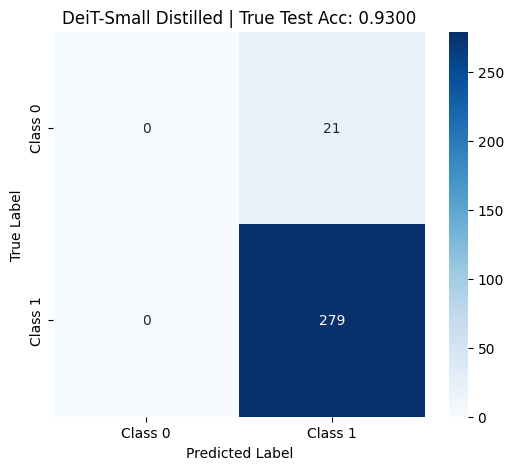


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        21
     Class 1       0.93      1.00      0.96       279

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.86      0.93      0.90       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

class TestDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = int(self.labels_df.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_set = TestDataset(
    img_dir='/content/test_set/test',
    csv_file='/content/test_set/test_labels.csv',
    transform=test_transform
)

test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
student = DeiTDistillSmall(num_classes=2).cuda()
student.load_state_dict(torch.load('/content/deit_small_distilled_2class.pth'))
student.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        cls_out, dist_out = student(inputs)
        cls_prob = F.softmax(cls_out, dim=1)
        dist_prob = F.softmax(dist_out, dim=1)
        final_prob = (cls_prob + dist_prob) / 2  
        pred = final_prob.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFINAL TEST ACCURACY (300 UNSEEN IMAGES): {test_acc:.4f} ({test_acc*100:.2f}%)")
print("ZERO DATA LEAKAGE — TRUE GENERALIZATION")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'DeiT-Small Distilled | True Test Acc: {test_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

In [ ]:
print("\n" + "="*60)
print("STARTING HARD DISTILLATION (Separate from Soft)")
print("="*60)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

student_hard = DeiTDistillSmall(num_classes=2).cuda()

teacher_hard = models.resnet50(weights=None)
teacher_hard.fc = nn.Linear(teacher_hard.fc.in_features, 2)
teacher_hard = teacher_hard.cuda()
teacher_hard.load_state_dict(torch.load('/content/finetuned_resnet50_2class.pth'))
for param in teacher_hard.parameters():
    param.requires_grad = False
teacher_hard.eval()

criterion_hard = nn.CrossEntropyLoss()
optimizer_hard = torch.optim.AdamW(student_hard.parameters(), lr=5e-4, weight_decay=0.05)
scheduler_hard = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_hard, T_max=100)

num_epochs_hard = 100
best_acc_hard = 0.0
save_path_hard = '/content/deit_small_hard_distilled_2class.pth'

print(f"Student: {sum(p.numel() for p in student_hard.parameters()):,} params")
print(f"Training for {num_epochs_hard} epochs → saving to: {save_path_hard}")


STARTING HARD DISTILLATION (Separate from Soft)
Student: 21,667,972 params
Training for 100 epochs → saving to: /content/deit_small_hard_distilled_2class.pth


In [ ]:
print("\n" + "="*60)
print("HARD DISTILLATION TRAINING STARTED")
print("="*60)

for epoch in range(num_epochs_hard):
    student_hard.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs_hard} [train]', leave=False):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer_hard.zero_grad()
        cls_out, _ = student_hard(inputs)


        with torch.no_grad():
            teacher_out = teacher_hard(inputs)
            teacher_pred = teacher_out.argmax(dim=1)  
        loss = criterion_hard(cls_out, teacher_pred)

        loss.backward()
        optimizer_hard.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_set)
    scheduler_hard.step()

    student_hard.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            cls_out, _ = student_hard(inputs)
            pred = cls_out.argmax(dim=1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    val_acc = correct / total
    print(f'Epoch {epoch+1:3d} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}')

    if val_acc > best_acc_hard:
        best_acc_hard = val_acc
        torch.save(student_hard.state_dict(), save_path_hard)
        print(f'  ---> BEST MODEL SAVED (acc = {best_acc_hard:.4f})')

print("\n" + "="*60)
print("HARD DISTILLATION TRAINING COMPLETE")
print(f"Best Validation Accuracy: {best_acc_hard:.4f}")
print(f"Model saved to: {save_path_hard}")
print("="*60)


HARD DISTILLATION TRAINING STARTED


Epoch   1 | Loss: 0.3600 | Val Acc: 0.9048
  ---> BEST MODEL SAVED (acc = 0.9048)


Epoch   2 | Loss: 0.2896 | Val Acc: 0.9048


Epoch   3 | Loss: 0.2969 | Val Acc: 0.9048


Epoch   4 | Loss: 0.3005 | Val Acc: 0.9048


Epoch   5 | Loss: 0.2855 | Val Acc: 0.9048


Epoch   6 | Loss: 0.2929 | Val Acc: 0.9048


Epoch   7 | Loss: 0.3005 | Val Acc: 0.9048


Epoch   8 | Loss: 0.2759 | Val Acc: 0.9048


Epoch   9 | Loss: 0.2874 | Val Acc: 0.9048


Epoch  10 | Loss: 0.2865 | Val Acc: 0.9048


Epoch  11 | Loss: 0.2770 | Val Acc: 0.9048


Epoch  12 | Loss: 0.2980 | Val Acc: 0.9048


Epoch  13 | Loss: 0.2960 | Val Acc: 0.9048


Epoch  14 | Loss: 0.2814 | Val Acc: 0.9048


Epoch  15 | Loss: 0.2730 | Val Acc: 0.9048


Epoch  16 | Loss: 0.2749 | Val Acc: 0.9048


Epoch  17 | Loss: 0.2856 | Val Acc: 0.9048


Epoch  18 | Loss: 0.2755 | Val Acc: 0.9048


Epoch  19 | Loss: 0.2861 | Val Acc: 0.9048


Epoch  20 | Loss: 0.2643 | Val Acc: 0.9048


Epoch  21 | Loss: 0.2771 | Val Acc: 0.9048


Epoch  22 | Loss: 0.2928 | Val Acc: 0.9048


Epoch  23 | Loss: 0.3157 | Val Acc: 0.9048


Epoch  24 | Loss: 0.2848 | Val Acc: 0.9048


Epoch  25 | Loss: 0.2788 | Val Acc: 0.9048


Epoch  26 | Loss: 0.2777 | Val Acc: 0.9048


Epoch  27 | Loss: 0.2805 | Val Acc: 0.9048


Epoch  28 | Loss: 0.2738 | Val Acc: 0.9048


Epoch  29 | Loss: 0.3130 | Val Acc: 0.9048


Epoch  30 | Loss: 0.3007 | Val Acc: 0.9048


Epoch  31 | Loss: 0.3071 | Val Acc: 0.9048


Epoch  32 | Loss: 0.2983 | Val Acc: 0.9048


Epoch  33 | Loss: 0.2813 | Val Acc: 0.9048


Epoch  34 | Loss: 0.2909 | Val Acc: 0.9048


Epoch  35 | Loss: 0.2941 | Val Acc: 0.9048


Epoch  36 | Loss: 0.3068 | Val Acc: 0.9048


Epoch  37 | Loss: 0.2836 | Val Acc: 0.9048


Epoch  38 | Loss: 0.2810 | Val Acc: 0.9048


Epoch  39 | Loss: 0.2890 | Val Acc: 0.9048


Epoch  40 | Loss: 0.2803 | Val Acc: 0.9048


Epoch  41 | Loss: 0.2860 | Val Acc: 0.9048


Epoch  42 | Loss: 0.2841 | Val Acc: 0.9048


Epoch  43 | Loss: 0.2783 | Val Acc: 0.9048


Epoch  44 | Loss: 0.2894 | Val Acc: 0.9048


Epoch  45 | Loss: 0.2970 | Val Acc: 0.9048


Epoch  46 | Loss: 0.2777 | Val Acc: 0.9048


Epoch  47 | Loss: 0.2694 | Val Acc: 0.9048


Epoch  48 | Loss: 0.2764 | Val Acc: 0.9048


Epoch  49 | Loss: 0.2733 | Val Acc: 0.9048


Epoch  50 | Loss: 0.2921 | Val Acc: 0.9048


Epoch  51 | Loss: 0.2739 | Val Acc: 0.9048


Epoch  52 | Loss: 0.2870 | Val Acc: 0.9048


Epoch  53 | Loss: 0.2772 | Val Acc: 0.9048


Epoch  54 | Loss: 0.2867 | Val Acc: 0.9048


Epoch  55 | Loss: 0.2830 | Val Acc: 0.9048


Epoch  56 | Loss: 0.2792 | Val Acc: 0.9048


Epoch  57 | Loss: 0.2948 | Val Acc: 0.9048


Epoch  58 | Loss: 0.2765 | Val Acc: 0.9048


Epoch  59 | Loss: 0.2824 | Val Acc: 0.9048


Epoch  60 | Loss: 0.2740 | Val Acc: 0.9048


Epoch  61 | Loss: 0.2733 | Val Acc: 0.9048


Epoch  62 | Loss: 0.2568 | Val Acc: 0.9048


Epoch  63 | Loss: 0.2619 | Val Acc: 0.9048


Epoch  64 | Loss: 0.2865 | Val Acc: 0.9048


Epoch  65 | Loss: 0.2662 | Val Acc: 0.9048


Epoch  66 | Loss: 0.2823 | Val Acc: 0.9048


Epoch  67 | Loss: 0.2675 | Val Acc: 0.9048


Epoch  68 | Loss: 0.2840 | Val Acc: 0.9048


Epoch  69 | Loss: 0.2670 | Val Acc: 0.9048


Epoch  70 | Loss: 0.2525 | Val Acc: 0.9048


Epoch  71 | Loss: 0.2715 | Val Acc: 0.9048


Epoch  72 | Loss: 0.2576 | Val Acc: 0.9048


Epoch  73 | Loss: 0.2520 | Val Acc: 0.9048


Epoch  74 | Loss: 0.2681 | Val Acc: 0.9048


Epoch  75 | Loss: 0.2553 | Val Acc: 0.9048


Epoch  76 | Loss: 0.2510 | Val Acc: 0.9048


Epoch  77 | Loss: 0.2611 | Val Acc: 0.9048


Epoch  78 | Loss: 0.2525 | Val Acc: 0.9048


Epoch  79 | Loss: 0.2617 | Val Acc: 0.9098
  ---> BEST MODEL SAVED (acc = 0.9098)


Epoch  80 | Loss: 0.2451 | Val Acc: 0.9048


Epoch  81 | Loss: 0.2479 | Val Acc: 0.9048


Epoch  82 | Loss: 0.2516 | Val Acc: 0.9048


Epoch  83 | Loss: 0.2469 | Val Acc: 0.9023


Epoch  84 | Loss: 0.2428 | Val Acc: 0.9048


Epoch  85 | Loss: 0.2451 | Val Acc: 0.9048


Epoch  86 | Loss: 0.2527 | Val Acc: 0.9048


Epoch  87 | Loss: 0.2564 | Val Acc: 0.9048


Epoch  88 | Loss: 0.2521 | Val Acc: 0.9048


Epoch  89 | Loss: 0.2516 | Val Acc: 0.9048


Epoch  90 | Loss: 0.2698 | Val Acc: 0.9048


Epoch  91 | Loss: 0.2511 | Val Acc: 0.9048


Epoch  92 | Loss: 0.2467 | Val Acc: 0.9048


Epoch  93 | Loss: 0.2512 | Val Acc: 0.9048


Epoch  94 | Loss: 0.2353 | Val Acc: 0.9048


Epoch  95 | Loss: 0.2572 | Val Acc: 0.9048


Epoch  96 | Loss: 0.2491 | Val Acc: 0.9048


Epoch  97 | Loss: 0.2478 | Val Acc: 0.9048


Epoch  98 | Loss: 0.2436 | Val Acc: 0.9048


Epoch  99 | Loss: 0.2538 | Val Acc: 0.9048


Epoch 100 | Loss: 0.2567 | Val Acc: 0.9048

HARD DISTILLATION TRAINING COMPLETE
Best Validation Accuracy: 0.9098
Model saved to: /content/deit_small_hard_distilled_2class.pth



FINAL TEST: HARD DISTILLED MODEL (300 UNSEEN IMAGES)

FINAL TEST ACCURACY (HARD DISTILLED): 0.9300 (93.00%)
ZERO DATA LEAKAGE — TRUE GENERALIZATION


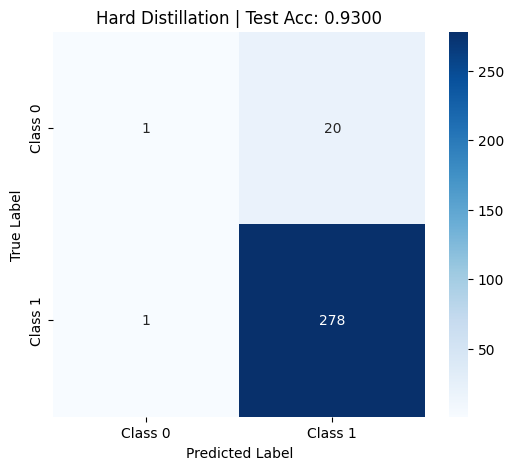


Classification Report (Hard Distillation):
              precision    recall  f1-score   support

     Class 0       0.50      0.05      0.09        21
     Class 1       0.93      1.00      0.96       279

    accuracy                           0.93       300
   macro avg       0.72      0.52      0.53       300
weighted avg       0.90      0.93      0.90       300


Balanced Accuracy: 0.5220
Recall (Class 0): 0.0476
Recall (Class 1): 0.9964
Macro F1: 0.5253


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score, balanced_accuracy_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("\n" + "="*60)
print("FINAL TEST: HARD DISTILLED MODEL (300 UNSEEN IMAGES)")
print("="*60)

class TestDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.labels_df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = int(self.labels_df.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_set = TestDataset(
    img_dir='/content/test_set/test',
    csv_file='/content/test_set/test_labels.csv',
    transform=test_transform
)

test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
student_hard = DeiTDistillSmall(num_classes=2).cuda()
student_hard.load_state_dict(torch.load('/content/deit_small_hard_distilled_2class.pth'))
student_hard.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        cls_out, _ = student_hard(inputs)  
        pred = cls_out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nFINAL TEST ACCURACY (HARD DISTILLED): {test_acc:.4f} ({test_acc*100:.2f}%)")
print("ZERO DATA LEAKAGE — TRUE GENERALIZATION")


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Hard Distillation | Test Acc: {test_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("\nClassification Report (Hard Distillation):")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))
balanced_acc = balanced_accuracy_score(all_labels, all_preds)
recall_0 = recall_score(all_labels, all_preds, pos_label=0)
recall_1 = recall_score(all_labels, all_preds, pos_label=1)
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\nBalanced Accuracy: {balanced_acc:.4f}")
print(f"Recall (Class 0): {recall_0:.4f}")
print(f"Recall (Class 1): {recall_1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")